In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/b2/scratch/ahringer/jj374/lab/relmapping


http://www.sciencedirect.com/science/article/pii/S0092867412014080
> Table S1. trans-Splice Sites, Transcription Start Sites, and csRNA Loci for Protein-Coding Genes and Transcription Start Sites for pri-miRNAs, Related to Figure 2. Analysis of C. elegans CapSeq and CIP-TAP, containing lists of trans-splice sites, transcription start sites, and sense and antisense csRNAs derived from protein coding genes. Also included is the list of the transcription start sites for pri-miRNAs.
> 
> For C. elegans analysis, reads were mapped to the genome (WormBase release WS215)

In [2]:
#!cd ~/relmapping/wget; wget -m --no-parent https://ars.els-cdn.com/content/image/1-s2.0-S0092867412014080-mmc1.xlsx
fp_ = 'wget/ars.els-cdn.com/content/image/1-s2.0-S0092867412014080-mmc1_B._TS_sites_for_protein_genes.csv'
df_ = pd.read_csv(fp_, skiprows=11)
df_['assigned_to_an_annotation'] = df_['transcript'].map(lambda x: x == x)
print('%d records, ~20,000 not assigned to an annotation:' % (len(df_)))
print(df_['assigned_to_an_annotation'].value_counts())

df_.head()

88936 records, ~20,000 not assigned to an annotation:
True     69109
False    19827
Name: assigned_to_an_annotation, dtype: int64


,chromosome,strand,start,reads,distance_to_transcript,transcript,covered_by_CapSeq,transcript type,assigned_to_an_annotation
0,I,+,4578,6,NaN,NaN,NaN,NaN,False
1,I,+,6302,12,NaN,NaN,NaN,NaN,False
2,I,+,9332,6,NaN,NaN,NaN,NaN,False
3,I,+,9421,12,-992.0,Y74C9A.2.3,Not,coding,True
4,I,+,11294,10,-201.0,Y74C9A.2.2,Not,coding,True


> Using a cutoff of one CapSeq read per 10 million total reads, and a requirement for a YR motif, our CapSeq data predicted approximately 64,000 candidate TS sites genome wide (Table S1B).

In [3]:
print(df_['transcript type'].value_counts())
m_ = df_['transcript type'] == "coding"
df_ = df_.loc[m_].reset_index(drop=True)
print('%d records with annotated as "coding"' % (len(df_.query('transcript == transcript')),))

coding               67528
ncRNA                  612
Coding_pseudogene      398
snoRNA                 277
pre-miRNA              182
snRNA                   71
RNA_pseudogene          36
scRNA                    4
miRNA                    1
Name: transcript type, dtype: int64
67528 records with annotated as "coding"


In [4]:
# Raw (Gu et al., 2012) TSS sites (=many assigned to multiple transcripts)
df_gu = pd.DataFrame()
df_gu['chrom'] = 'chr' + df_['chromosome']
df_gu['start'] = df_['start']
df_gu['end'] = df_['start'] + 1
df_gu['name'] = df_['transcript']
df_gu['score'] = df_['reads']
df_gu['strand'] = df_['strand']
df_gu = df_gu.sort_values(['chrom', 'start', 'end', 'start']).reset_index(drop=True)

fp_ = 'annot/Fig2S5_tss/Gu2012/Gu2012_tss.bed'
write_gffbed(fp_,
    chrom = df_gu['chrom'],
    start = df_gu['start'],
    end = df_gu['end'],
    name = df_gu['name'],
    strand = df_gu['strand'],
    score = df_gu['score'],
)
!wc -l {fp_}

67529 annot/Fig2S5_tss/Gu2012/Gu2012_tss.bed


In [5]:
# Collapse TSS annotations by chrom/start/end/strand (raw TSS assignments are to all "compatible" transcripts)
fp_ = 'annot/Fig2S5_tss/Gu2012/Gu2012_tss_unique.bed'
df_gu.groupby(['chrom', 'start', 'end', 'strand']).agg({
        'name': lambda l: os.path.commonprefix(list(l)).rstrip('.'),#lambda l: ','.join(sorted(set(l))),
        'score': np.sum,
})\
.reset_index().sort_values(['chrom', 'start', 'end', 'strand'])[['chrom', 'start', 'end', 'name', 'score', 'strand']]\
.to_csv(fp_, sep='\t', index=False, header=False)
!wc -l {fp_}

42812 annot/Fig2S5_tss/Gu2012/Gu2012_tss_unique.bed


In [6]:
# Cluster TSS annotations using single-linkage, strand-specific, using a distance cutoff of 50
df_gu_cluster50_ = BedTool.from_dataframe(df_gu).cluster(d=50, s=True).to_dataframe()
df_gu_cluster50_.columns = ('chrom', 'start', 'end', 'transcript_id', 'score', 'strand', 'cluster_id')

fp_ = 'annot/Fig2S5_tss/Gu2012/Gu2012_tss_clustered.bed'
df_gu_cluster50 = df_gu_cluster50_.groupby('cluster_id').agg({
        'chrom': lambda s: list(set(s))[0],
        'start': np.min,
        'end': np.max,
        'transcript_id': lambda l: os.path.commonprefix(list(l)).rstrip('.'),#lambda l: ','.join(sorted(set(l))),
        'score': np.sum,
        'strand': lambda s: list(set(s))[0],
})\
.sort_values(['chrom', 'start', 'end', 'strand']).reset_index(drop=True)
df_gu_cluster50.to_csv(fp_, sep='\t', index=False, header=False)
!wc -l {fp_}

14363 annot/Fig2S5_tss/Gu2012/Gu2012_tss_clustered.bed


coding_promoter        5341
pseudogene_promoter      30
unknown_promoter        275
putative_enhancer      1099
non-coding_RNA           27
\n\nother_element       180
Name: name, dtype: int64

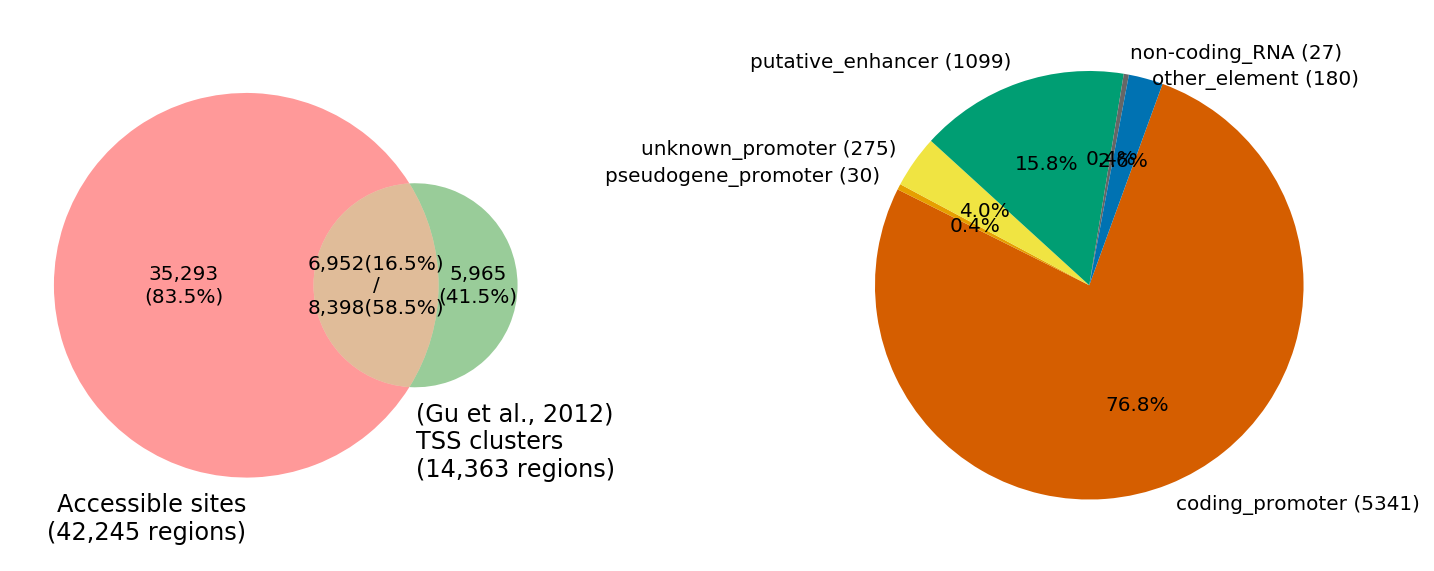

In [9]:
# Overlaps to TSS clusters
df_regl_ = regl_mode(flank_len=150)
df_regl_['annot'] = regl_()['annot']

gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_gu_cluster50[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Gu et al., 2012)\nTSS clusters',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
gv.plot()

plt.subplot(1,2,2)
annot_count_ = gv.df_a_with_b['name'].value_counts()[config['annot']]
annot_count_.index = [
    'coding_promoter',
    'pseudogene_promoter',
    'unknown_promoter',
    'putative_enhancer',
    'non-coding_RNA',
    '\n\nother_element'
]
#plt.title('Annotation of %d accessible sites that overlap a TSS from (Gu et al., 2012)' % (len(gv.df_a_with_b),))
plt.pie(
    annot_count_.values,
    labels = ['%s (%d)' % (l, c) for l, c in annot_count_.iteritems()],
    colors=[yp.RED, yp.ORANGE, yp.YELLOW, yp.GREEN, '0.4', yp.BLUE],
    counterclock=False,
    startangle=70,
    autopct='%.1f%%',
);
plt.gca().set_aspect('equal')
plt.savefig('annot/Fig2S5_tss/Gu2012_annot.pdf', bbox_inches='tight', transparent=True)
annot_count_

In [8]:
#fp_ = 'annot/Fig2S4_TSS/Gu2012_not_atac.bed'
#gv.df_b_only.to_csv(fp_, header=False, sep='\t', index=False)
#!wc -l {fp_}